## Submitted by Deepak - EVA 5 - week 4 assignment

### Import the required libraries


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Model summary

## *The network is built to meet the following constraints*

### 99.4% validation accuracy
### Less than 20k Parameters
### Less than 20 Epochs
### No fully connected layer

\begin{array}{ccc}
\text{Layer}&\text{Input}&\text{Output}&\text{Receptive Field}\\
Conv1&28*28*1&26*26*14&3*3\\
Conv2&26*26*14&24*24*30&5*5\\
Pool1&24*24*30&12*12*30&10*10\\
Conv3&12*12*30&12*12*14&10*10\\
Conv4&12*12*14&10*10*30&12*12\\
Conv5&10*10*30&8*8*39&14*14\\
Conv6&8*8*39&8*8*10&14*14\\
AvgPool&8*8*10&1*1*10&14*14\\
\end{array}


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        c_in = 16
        self.conv1 = nn.Conv2d(1, c_in-2, 3) #, padding=1) #input -? OUtput? RF
        self.bn1 = nn.BatchNorm2d(c_in-2)
        self.conv2 = nn.Conv2d(c_in-2, (c_in - 1)*2, 3) #, padding=1)
        self.bn2 = nn.BatchNorm2d((c_in - 1)*2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.do1 = nn.Dropout(0.05)
        self.conv1x1_1 = nn.Conv2d((c_in - 1)*2, c_in-2, 1)
        self.conv3 = nn.Conv2d( c_in-2, (c_in -1)*2, 3) #, padding=1)
        self.bn3 = nn.BatchNorm2d((c_in - 1)*2)
        self.conv4 = nn.Conv2d((c_in -1)*2, (c_in -3 )*3, 3) #, padding=1)
        self.bn4 = nn.BatchNorm2d((c_in - 3)*3)
        self.do2 = nn.Dropout(0.10)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv1x1_2 = nn.Conv2d((c_in - 3)*3, 10, 1)
        self.avgpool = nn.AvgPool2d(8)

    def forward(self, x):
        x = self.conv1x1_1 ((self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))))))
        x = (self.conv1x1_2 (F.relu(self.bn4((self.conv4(F.relu(self.bn3(self.conv3(x)))))))))
        x = self.avgpool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28 , 28 ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             140
       BatchNorm2d-2           [-1, 14, 26, 26]              28
            Conv2d-3           [-1, 30, 24, 24]           3,810
       BatchNorm2d-4           [-1, 30, 24, 24]              60
         MaxPool2d-5           [-1, 30, 12, 12]               0
            Conv2d-6           [-1, 14, 12, 12]             434
            Conv2d-7           [-1, 30, 10, 10]           3,810
       BatchNorm2d-8           [-1, 30, 10, 10]              60
            Conv2d-9             [-1, 39, 8, 8]          10,569
      BatchNorm2d-10             [-1, 39, 8, 8]              78
           Conv2d-11             [-1, 10, 8, 8]             400
        AvgPool2d-12             [-1, 10, 1, 1]               0
Total params: 19,389
Trainable params: 19,389
Non-trainable params: 0
---------------------------------

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### Helper function to load train and test mnist data

#### The following transforms are done on the train data

##### *RandomAffine* - An affine transformation is any transformation that preserves collinearity (i.e., all points lying on a line initially still lie on a line after transformation) and ratios of distances (e.g., the midpoint of a line segment remains the midpoint after transformation).

##### *RandomCrop* - Part of image is randomly blacked out

#### In addition the following transforms are done on both train and test data

##### *shuffle* - flag is set to true

##### *Normalize* - image  is normalized with a mean of 0.1307 and std. deviation of 0.3081

In [4]:


torch.manual_seed(1)
batch_size = 64 

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                        transforms.RandomCrop(28 , padding = 1),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) 
                        
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


### train and test helper method

In [6]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

testloss = []
testaccy = []
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    testloss.append(test_loss)
    testaccy.append(100. * correct / len(test_loader.dataset))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Run the model for 19 epochs 

### use SGD optimizer 

In [7]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.018, momentum=0.9)

for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    print('Epoch - {}\n'.format(epoch))
    test(model, device, test_loader)
    

loss=0.09876122325658798 batch_id=937: 100%|██████████| 938/938 [00:25<00:00, 36.83it/s]

Epoch - 1




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0810, Accuracy: 9759/10000 (97.590%)



loss=0.2905258536338806 batch_id=937: 100%|██████████| 938/938 [00:25<00:00, 36.65it/s]

Epoch - 2




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9853/10000 (98.530%)



loss=0.049301594495773315 batch_id=937: 100%|██████████| 938/938 [00:26<00:00, 35.75it/s]

Epoch - 3




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9878/10000 (98.780%)



loss=0.03533579409122467 batch_id=937: 100%|██████████| 938/938 [00:26<00:00, 35.52it/s]

Epoch - 4




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9891/10000 (98.910%)



loss=0.17861801385879517 batch_id=937: 100%|██████████| 938/938 [00:26<00:00, 35.25it/s]

Epoch - 5




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9903/10000 (99.030%)



loss=0.15533387660980225 batch_id=937: 100%|██████████| 938/938 [00:26<00:00, 35.72it/s]

Epoch - 6




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9908/10000 (99.080%)



loss=0.035468753427267075 batch_id=937: 100%|██████████| 938/938 [00:25<00:00, 36.33it/s]

Epoch - 7




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9903/10000 (99.030%)



loss=0.20510917901992798 batch_id=937: 100%|██████████| 938/938 [00:24<00:00, 37.63it/s]


Epoch - 8



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.250%)



loss=0.0034449449740350246 batch_id=937: 100%|██████████| 938/938 [00:26<00:00, 35.93it/s]

Epoch - 9




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9901/10000 (99.010%)



loss=0.05026432126760483 batch_id=937: 100%|██████████| 938/938 [00:26<00:00, 35.03it/s]

Epoch - 10




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9901/10000 (99.010%)



loss=0.00823606550693512 batch_id=937: 100%|██████████| 938/938 [00:26<00:00, 35.27it/s]

Epoch - 11




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9924/10000 (99.240%)



loss=0.020199524238705635 batch_id=937: 100%|██████████| 938/938 [00:26<00:00, 34.82it/s]

Epoch - 12




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9926/10000 (99.260%)



loss=0.04861758276820183 batch_id=937: 100%|██████████| 938/938 [00:26<00:00, 35.88it/s]

Epoch - 13




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9904/10000 (99.040%)



loss=0.2007114440202713 batch_id=937: 100%|██████████| 938/938 [00:26<00:00, 36.03it/s]

Epoch - 14




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.370%)



loss=0.0058024669997394085 batch_id=937: 100%|██████████| 938/938 [00:25<00:00, 36.52it/s]


Epoch - 15



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.390%)



loss=0.015188601799309254 batch_id=937: 100%|██████████| 938/938 [00:25<00:00, 36.64it/s]

Epoch - 16




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.410%)



loss=0.15332554280757904 batch_id=937: 100%|██████████| 938/938 [00:25<00:00, 36.73it/s]

Epoch - 17




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.300%)



loss=0.10155099630355835 batch_id=937: 100%|██████████| 938/938 [00:25<00:00, 36.69it/s]

Epoch - 18




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.340%)



loss=0.024822844192385674 batch_id=937: 100%|██████████| 938/938 [00:25<00:00, 37.25it/s]

Epoch - 19




Test set: Average loss: 0.0187, Accuracy: 9944/10000 (99.440%)



### The model is run for 19 epochs and test accuracy achieved in 99.44%

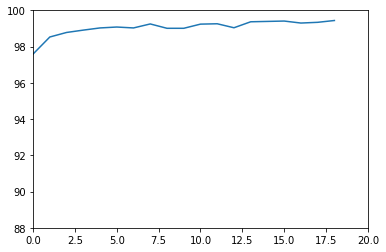

In [8]:
import matplotlib.pyplot as plt

plt.plot( testaccy)
plt.axis([0, 20, 88, 100])
plt.show()
